# Определение перспективного тарифа для телеком компании


<strong>Данные</strong>

Выборка из 500 пользователей за 2018 год. Мы знаем каким тарифом они пользуются, что включено в пакет услуг, стоимость тарифа, сколько звонков, сообщений и интернет-траффика они использовали за год, из каких они регионов. 

<strong>Задача</strong>

Определить какой тариф оптимальней

## 1. Открываем данные, изучаем общую информацию

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import math

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
calls.info()
print()
internet.info()
print()
messages.info()
print()
tariffs.info()
print()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

<class 'pandas.core.frame.DataFrame'>
R

# 2. Меняем типы данных, исправляем ошибки в данных, делаем предварительные расчеты

Поменяем типы столбцов с датами на datetime, чтобы можно было работать с датами

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y.%m.%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y.%m.%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y.%m.%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y.%m.%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y.%m.%d')

Пропуски есть только в таблице users в столбце 'churn_date', это значит, что пользователь еще использует тариф, эти пропуски заменять не будем. Продолжительность звонков в 0 сек. оставим, приняв их за пропущенные звонки

In [5]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


В датасете 'internet' есть столбец 'Unnamed:0', который просто дублирует индексы и не несет какую-либо полезную для аналитики информацию, удалим ее

In [6]:
internet = internet.drop(['Unnamed: 0'], axis = 'columns')

В табличке calls добавим столбец с округленными вверх значениями минут, поскольку оператор округляет каждый разговор, считать будем по этому столбцу. А столбец с интернет-траффиком пока округлять не будем, поскольку он округляется раз в месяц, а не во время каждой сессии.

In [7]:
calls['duration_round'] = calls['duration'].apply(math.ceil)

# Расчеты

Создадим табличку с месяцами

In [8]:
min_month = calls['call_date'].values.astype('datetime64[M]').min()

In [9]:
max_month = calls['call_date'].values.astype('datetime64[M]').max()

In [10]:
pd.date_range(min_month, max_month, freq='MS')

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [11]:
month = pd.DataFrame(pd.date_range(min_month, max_month, freq='MS'))

In [12]:
month

,0
0,2018-01-01
1,2018-02-01
2,2018-03-01
3,2018-04-01
4,2018-05-01
5,2018-06-01
6,2018-07-01
7,2018-08-01
8,2018-09-01
9,2018-10-01


In [13]:
month.columns = ['month']

Смерджим с табличкой users

In [14]:
len(users)*len(month)

6000

Должно получиться 6000 строчек

In [15]:
month['key'] = 1
users['key'] = 1

In [16]:
df = month.merge(users, on='key')
df.head()

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,2018-01-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,2018-01-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,2018-01-01,1,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,2018-01-01,1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,2018-01-01,1,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Всё совпадает. Теперь оставим только те строки, где даты больше чем дата регистрации пользователя. и уберем те, где даты больше, чем дата отключения.

In [17]:
len(df[df['month'] >= df['reg_date']])

2776

In [18]:
len(df[df['month'] >= df['churn_date']])

43

In [19]:
df = df.query('~(month >= churn_date) and (month >= reg_date)')
df.head()

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
193,2018-01-01,1,1193,55,NaT,Тамбов,Арсен,Безруков,2018-01-01,smart
453,2018-01-01,1,1453,50,NaT,Москва,Кузьма,Акуленко,2018-01-01,ultra
505,2018-02-01,1,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
532,2018-02-01,1,1032,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart
545,2018-02-01,1,1045,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart


Подготовим таблички, сгруппированные по юзерам и месяцам, которые можно будет смерджить с df

In [20]:
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

In [21]:
calls.head()

,id,call_date,duration,user_id,duration_round,month
0,1000_0,2018-07-25,0.00,1000,0,2018-07-01
1,1000_1,2018-08-17,0.00,1000,0,2018-08-01
2,1000_2,2018-06-11,2.85,1000,3,2018-06-01
3,1000_3,2018-09-21,13.80,1000,14,2018-09-01
4,1000_4,2018-12-15,5.18,1000,6,2018-12-01


In [22]:
user_calls = calls.groupby(['user_id', 'month'])['duration_round'].agg({'count', 'sum'}).reset_index()
user_calls = user_calls.rename(columns={'sum': 'calls_duration', 'count': 'calls_count'})
user_calls.head()

,user_id,month,calls_count,calls_duration
0,1000,2018-05-01,22,159
1,1000,2018-06-01,43,172
2,1000,2018-07-01,47,340
3,1000,2018-08-01,52,408
4,1000,2018-09-01,58,466


In [23]:
df = df.merge(user_calls, how='left', on=['user_id', 'month'])

In [24]:
df.sample(5)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_count,calls_duration
1389,2018-09-01,1,1337,42,NaT,Вологда,Олег,Суслов,2018-01-15,smart,18.0,97.0
106,2018-03-01,1,1395,66,NaT,Москва,Радомир,Кондратов,2018-01-06,smart,92.0,668.0
1840,2018-10-01,1,1447,25,NaT,Москва,Александра,Алешина,2018-09-13,smart,86.0,652.0
1483,2018-09-01,1,1468,29,NaT,Тамбов,Иван,Авдышев,2018-02-11,smart,30.0,177.0
1552,2018-10-01,1,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart,44.0,277.0


Сделаем тоже самое с табличкой internet

In [25]:
internet['month'] = internet['session_date'].values.astype('datetime64[M]')
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,2018-11-01
1,1000_1,1052.81,2018-09-07,1000,2018-09-01
2,1000_2,1197.26,2018-06-25,1000,2018-06-01
3,1000_3,550.27,2018-08-22,1000,2018-08-01
4,1000_4,302.56,2018-09-24,1000,2018-09-01


In [26]:
user_internet = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
user_internet.head()

,user_id,month,mb_used
0,1000,2018-05-01,2253.49
1,1000,2018-06-01,23233.77
2,1000,2018-07-01,14003.64
3,1000,2018-08-01,14055.93
4,1000,2018-09-01,14568.91


In [27]:
df = df.merge(user_internet, how='left', on=['user_id', 'month'])

In [28]:
df.sample(5)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_count,calls_duration,mb_used
1569,2018-10-01,1,1091,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,NaN,NaN,15644.73
1270,2018-09-01,1,1158,45,NaT,Новокузнецк,Игорь,Андрейчук,2018-02-03,smart,43.0,322.0,13085.43
2240,2018-11-01,1,1437,73,NaT,Казань,Лилия,Селезнева,2018-08-03,smart,37.0,199.0,21019.07
2516,2018-12-01,1,1259,33,NaT,Санкт-Петербург,Эмилия,Третьякова,2018-11-04,ultra,106.0,830.0,12136.62
2505,2018-12-01,1,1244,68,NaT,Москва,Геральд,Макеев,2018-05-09,smart,44.0,272.0,22786.67


Сделаем тоже самое с табличкой messages

In [29]:
messages['month'] = messages['message_date'].values.astype('datetime64[M]')
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01


In [30]:
user_messages = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
user_messages = user_messages.rename(columns={'id': 'messages_count'})
user_messages.head()

,user_id,month,messages_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


In [31]:
df = df.merge(user_messages, how='left', on=['user_id', 'month'])

In [32]:
df.sample(5)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_count,calls_duration,mb_used,messages_count
1130,2018-08-01,1,1433,71,NaT,Подольск,Клариса,Алёшкова,2018-01-05,smart,78.0,520.0,13758.51,79.0
1,2018-01-01,1,1453,50,NaT,Москва,Кузьма,Акуленко,2018-01-01,ultra,128.0,861.0,19450.33,50.0
2348,2018-12-01,1,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart,46.0,337.0,20424.72,26.0
1019,2018-08-01,1,1247,19,NaT,Москва,Адам,Тарасов,2018-05-23,smart,66.0,489.0,22773.39,31.0
2225,2018-11-01,1,1421,30,NaT,Калининград,Гайдар,Александрович,2018-02-22,smart,35.0,253.0,24778.80,48.0


Теперь смерджим табличку df с табличкой tariffs

In [33]:
df = df.merge(tariffs, how='left', left_on=['tariff'], right_on=['tariff_name'])
df.head()

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_count,calls_duration,mb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,2018-01-01,1,1193,55,NaT,Тамбов,Арсен,Безруков,2018-01-01,smart,53.0,388.0,7136.31,24.0,50,15360,500,550,200,3,3,smart
1,2018-01-01,1,1453,50,NaT,Москва,Кузьма,Акуленко,2018-01-01,ultra,128.0,861.0,19450.33,50.0,1000,30720,3000,1950,150,1,1,ultra
2,2018-02-01,1,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,69.0,456.0,7383.93,38.0,50,15360,500,550,200,3,3,smart
3,2018-02-01,1,1032,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,58.0,371.0,12492.34,36.0,50,15360,500,550,200,3,3,smart
4,2018-02-01,1,1045,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,27.0,189.0,14795.68,49.0,50,15360,500,550,200,3,3,smart


Теперь можем приступать к расчетам

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2733 entries, 0 to 2732
Data columns (total 22 columns):
month                    2733 non-null datetime64[ns]
key                      2733 non-null int64
user_id                  2733 non-null int64
age                      2733 non-null int64
churn_date               151 non-null datetime64[ns]
city                     2733 non-null object
first_name               2733 non-null object
last_name                2733 non-null object
reg_date                 2733 non-null datetime64[ns]
tariff                   2733 non-null object
calls_count              2700 non-null float64
calls_duration           2700 non-null float64
mb_used                  2726 non-null float64
messages_count           2319 non-null float64
messages_included        2733 non-null int64
mb_per_month_included    2733 non-null int64
minutes_included         2733 non-null int64
rub_monthly_fee          2733 non-null int64
rub_per_gb               2733 non-null int64


Мы видим, что в столбцах 'calls_duration', 'calls_count', 'mb_used', 'messages_count' есть пропуски. Хотя в таблицах-источниках пропусков по соответствующим столбцам не было, это говорит о том, что при присоединении таблиц в правой таблице не было соответствующих левой таблице значений, то есть по факту это нули, поэтому заменим пропуски в этих столбцах на 0.

In [35]:
df['calls_duration'] = df['calls_duration'].fillna(0)
df['calls_count'] = df['calls_count'].fillna(0)
df['mb_used'] = df['mb_used'].fillna(0)
df['messages_count'] = df['messages_count'].fillna(0)

Напишем функции, которые отрицательные значения превращают в 0, положительные оставляют. Применим их к таблице и создадим 3 новых столбца со значениями остатков по пакетам минут, смс и интернета

In [36]:
def minutes_rest(row):
    if (row['calls_duration'] - row['minutes_included']) < 0:
        return '0'
    return (row['calls_duration'] - row['minutes_included'])

In [37]:
df['minutes_rest'] = df.apply(minutes_rest, axis=1)

In [38]:
def mb_rest(row):
    if (row['mb_used'] - row['mb_per_month_included']) < 0:
        return '0'
    return (row['mb_used'] - row['mb_per_month_included'])

In [39]:
df['mb_rest'] = df.apply(mb_rest, axis=1)

In [40]:
def messages_rest(row):
    if (row['messages_count'] - row['messages_included']) < 0:
        return '0'
    return (row['messages_count'] - row['messages_included'])

In [41]:
df['messages_rest'] = df.apply(messages_rest, axis=1)

In [42]:
df.tail(5)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_count,calls_duration,mb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,minutes_rest,mb_rest,messages_rest
2728,2018-12-01,1,1494,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,62.0,418.0,17621.21,0.0,50,15360,500,550,200,3,3,smart,0,2261.21,0
2729,2018-12-01,1,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,155.0,1031.0,23426.76,84.0,1000,30720,3000,1950,150,1,1,ultra,0,0,0
2730,2018-12-01,1,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,80.0,518.0,20736.15,51.0,50,15360,500,550,200,3,3,smart,18,5376.15,1
2731,2018-12-01,1,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,71.0,545.0,19918.60,17.0,50,15360,500,550,200,3,3,smart,45,4558.6,0
2732,2018-12-01,1,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,69.0,492.0,13055.58,66.0,50,15360,500,550,200,3,3,smart,0,0,16


Поскольку оператор округляет вверх значения мегабайтов, то округлим значения в столбце 'mb_rest'. Сохраним в новом столбце 'mb_rest_round_up'

In [43]:
def roundup(x):
    return int(math.ceil(x / 1000.0)) * 1000

In [44]:
df['mb_rest_round_up']= df['mb_rest'].astype('int').apply(roundup)

In [45]:
df.sample(5)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_count,calls_duration,mb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,minutes_rest,mb_rest,messages_rest,mb_rest_round_up
1962,2018-11-01,1,1102,28,NaT,Москва,Марта,Королькова,2018-06-16,smart,72.0,362.0,20734.63,34.0,50,15360,500,550,200,3,3,smart,0,5374.63,0,6000
2640,2018-12-01,1,1401,42,NaT,Москва,Владислава,Васильева,2018-01-24,smart,46.0,351.0,11787.27,49.0,50,15360,500,550,200,3,3,smart,0,0,0,0
2554,2018-12-01,1,1302,43,NaT,Уфа,Владислав,Абаимов,2018-01-23,smart,31.0,190.0,14344.60,101.0,50,15360,500,550,200,3,3,smart,0,0,51,0
1644,2018-10-01,1,1191,64,2018-10-03,Набережные Челны,Александр,Акиндинов,2018-06-30,smart,5.0,41.0,1175.74,8.0,50,15360,500,550,200,3,3,smart,0,0,0,0
518,2018-06-01,1,1247,19,NaT,Москва,Адам,Тарасов,2018-05-23,smart,55.0,401.0,25047.01,29.0,50,15360,500,550,200,3,3,smart,0,9687.01,0,10000


Поменяем тип в столбцах 'minutes_rest', 'messages_rest' на инт, для проведения дальнейших расчетов

In [46]:
df['minutes_rest'] = df['minutes_rest'].astype('int')
df['messages_rest'] = df['messages_rest'].astype('int')

Считаем выручку, сохраняем ее в новом столбце 'revenue'

In [47]:
df['revenue'] = df['minutes_rest'] * df['rub_per_minute'] + (df['mb_rest_round_up']/1000) * df['rub_per_gb'] + df['messages_rest'] * df['rub_per_message'] + df['rub_monthly_fee']

In [48]:
df.sample(5)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_count,calls_duration,mb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,minutes_rest,mb_rest,messages_rest,mb_rest_round_up,revenue
1480,2018-09-01,1,1464,44,NaT,Саранск,Антонина,Авросинова,2018-02-17,smart,74.0,542.0,16804.19,21.0,50,15360,500,550,200,3,3,smart,42,1444.19,0,2000,1076.0
140,2018-04-01,1,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart,44.0,363.0,17905.94,33.0,50,15360,500,550,200,3,3,smart,0,2545.94,0,3000,1150.0
649,2018-07-01,1,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart,48.0,348.0,20882.89,3.0,50,15360,500,550,200,3,3,smart,0,5522.89,0,6000,1750.0
32,2018-02-01,1,1381,64,NaT,Москва,Тамара,Серебрякова,2018-01-13,ultra,98.0,762.0,27738.28,44.0,1000,30720,3000,1950,150,1,1,ultra,0,0,0,0,1950.0
998,2018-08-01,1,1209,27,NaT,Омск,Альбин,Сорокин,2018-06-02,smart,40.0,252.0,22284.73,88.0,50,15360,500,550,200,3,3,smart,0,6924.73,38,7000,2064.0


# Шаг 3. Анализируем данные

In [49]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
df.groupby('tariff')['calls_duration'].agg({'calls_duration': ['mean', 'median', 'std', 'var']})

calls_duration                                 
                 mean median         std           var
tariff                                                
smart      450.074153  452.0  177.202239  31400.633608
ultra      567.144379  559.0  309.755228  95948.301405

Среднее и медианное значение кол-ва минут в месяц не сильно отличаются. В среднем пользователям тарифа смарт нужно 450 минут в месяц, а тарифа ультра 567 минут, видимо, среди пользователей тарифа ультра многие не используют пакет включенных минут даже на половину, а пользователи тарифа смарт пользуются по-умному: используют почти весь пакет, но не выходят за его пределы.
Стандартное отклонение в тарифе ультра выше, чем в смарт, значит среди пользователей этого тарифа есть те, кто возможно любит поговорить намного больше или меньше, чем пользователи в среднем.

In [52]:
df.groupby('tariff')['mb_used'].agg({'mb_used': ['mean', 'median', 'std', 'var']})

mb_used                                      
                mean     median          std           var
tariff                                                    
smart   17457.993347  17279.275  4950.753722  2.450996e+07
ultra   20876.668166  20478.750  9625.914720  9.265823e+07

В среднем пользователи тарифа "смарт" выходят за пределы включенных в тариф мегабайтов и оплачивают дополнительно интернет-траффик порядка 600 рублей в месяц, что превращает их в очень выгодных клиентов, а вот пользователи "ультра" редко используют дополнительные мб, в основном укладываются в положенные 30гб, но они оплачивают высокую тарифную ставку, что также превращает их в выгодных клиентов

In [53]:
df.groupby('tariff')['messages_count'].agg({'messages_count': ['mean', 'median', 'std', 'var']})

messages_count                               
                 mean median        std          var
tariff                                              
smart       35.936970   31.0  28.656838   821.214361
ultra       52.642604   42.0  48.729888  2374.601974

Пользователи тарифа смарт отправляют в среднем 35 смс в месяц, и укладываются в тарифный пакет в 50 смс. А вот пользователи "ультра" отправляют в среднем всего на 17 смс больше, что равно 52-ум, но при этом оплачивают тариф, в который входит 1000 смс в месяц. Кажется, они используют тариф не очень рационально.

In [54]:
df.groupby('tariff')['revenue'].agg({'revenue': ['mean', 'median', 'std', 'var']})

revenue                                   
               mean  median         std            var
tariff                                                
smart   1411.966631  1165.5  843.641285  711730.618388
ultra   2090.946746  1950.0  411.243408  169121.140526

Средняя выручка по тарифу смарт 1411 руб, по тарифу Ультра 2090руб, по тарифу Ультра средняя выручка ненамного выше, чем стоимость тарифного плана, а медианное значение вообще совпадает, то есть пользователи ультра редко переплачивают. А вот пользователи смарт, переплачивают в среднем в 2 раза больше месячной стоимости тарифа.

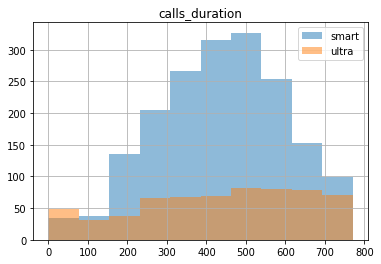

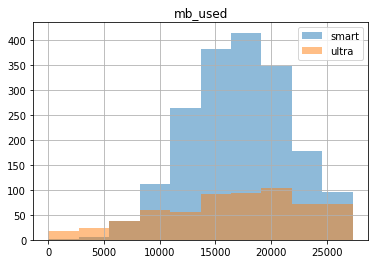

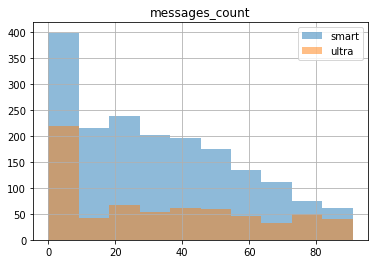

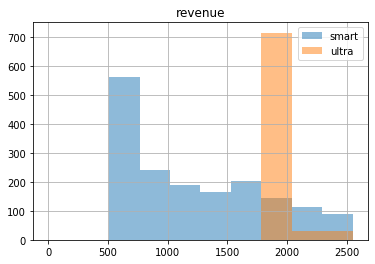

In [55]:
for element in ['calls_duration', 'mb_used', 'messages_count', 'revenue']:
    for tariff_name in df['tariff'].unique():
        (df.query('tariff == @tariff_name')[element].hist(bins=10, alpha=0.5, label = tariff_name, range=(0, df[element].quantile(0.9))))
    plt.title(element)
    plt.legend()
    plt.show()

Практически все пользователи тарифа "ультра" разговаривают до 800 минут в месяц, даже не смотря на то, что они выбрали тариф с 3000 минутами в месяц. Пик по используемым мб приходится на 20гб, практически все укладываются в положенные 30гб интернета и не платят за дополнительные гб. Многие отправляют меньше 10 смс в месяц, и укладываются в положенные тарифом аж 1000 смс в месяц, что неудивительно в век мессенджеров и соцсетей. Можно сказать, что пользователи тарифа "ультра" в основном укладываются в стоимость своего тарифного плана 1950, и очень редко платят сверх тарифного плана. Также видим, что большая часть выручки приходит от тарифа Смарт.

Большинство пользователей тарифа смарт разговаривают до 500 минут в месяц, однако есть и те, кто разговаривает больше и платит за дополнительные минуты. А вот укладываются в положенные 15 гб интернета меньше половины пользователей, есть даже те, кто расходует по 25 гб, оплачивая аж до 2000руб за перерасход гб. Смс также не очень популярен среди пользователей "смарта", однако некоторые умудряются перерасходовать пакет в 50 смс и оплачивают дополнительные смс. Большинство пользователей платят сверх стоимости тарифного плана в месяц. Тариф Смарт приносит больше денег, чем Ультра.

In [56]:
len(df[df['tariff'] == "ultra"])

845

In [57]:
len(df[df['tariff'] == "smart"])

1888

In [58]:
len(df[df['tariff'] == "ultra"])/len(df)

0.30918404683497985

In [59]:
df[df['tariff'] == 'smart']['revenue'].sum()/df['revenue'].sum()

0.6014003383534383

In [60]:
df[df['tariff'] == 'ultra']['revenue'].sum()/df['revenue'].sum()

0.39859966164656163

60% выручки приносит тариф "Смарт", а "Ультра" 40%. При этом кол-во пользователей Ультра = 30%, а Смарт - 70%. Смарт популярнее и приносит больше денег.

# Шаг 4. Проверка гипотез

In [61]:
from scipy import stats as st

### Проверка первой гипотезы

Первая выборка: пользователи тарифа Смарт

In [62]:
sample1_1 = df[df['tariff'] == 'smart']['revenue']

In [63]:
len(sample1_1)

1888

Вторая выборка: пользователи тарифа Ультра

In [64]:
sample1_2 = df[df['tariff'] == 'ultra']['revenue']

In [65]:
len(sample1_2)

845

Выдвигаем нулевую гипотезу: среднее двух генеральных совокупностей равно. Соответственно, альтернативная гипотеза: среднее двух генеральных совокупностей различается

In [66]:
alpha = .05

In [67]:
results1 = st.ttest_ind(sample1_1, sample1_2)

In [68]:
results1.pvalue

7.406209138357743e-101

In [69]:
if (results1.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть гипотезу')

Отвергаем нулевую гипотезу


Отвергаем гипотезу о равенстве средних двух ген-х совокупностей, значит они разные. То есть мы имеем разную среднюю выручку с разных тарифов

### Проверка второй гипотезы

In [70]:
sample2_1 = df[df['city'] == 'Москва']['revenue']

In [71]:
sample2_2 = df[df['city'] != 'Москва']['revenue']

In [72]:
len(sample2_1)

519

In [73]:
len(sample2_2)

2214

Выдвигаем нулевую гипотезу: средние выручки пользователей из Москвы и регионов равны. Следовательно, альтернативная гипотеза: средние выручки пользователей из Москвы и регионов различаются.

In [74]:
results2 = st.ttest_ind(sample2_1, sample2_2)

In [75]:
results2.pvalue

0.5575394766126038

In [76]:
if (results2.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Не получилось отвергнуть нулевую гипотезу


Поскольку нулевую гипотезу не получилось отвергнуть, значит, что средние выручки из Москвы и регинов необязательно отличаются

Критерием для проверки гипотез является значение p-value, сравниваем его с aplha в 5%, то есть с вероятностью того, что вычисленное значение окажется далеко от среднего

# Вывод

Мы можем сделать вывод о том, что тарифы приносят разную выручку. Тариф Смарт популярнее и приносит больше денег, около 70% пользователей и около 60% от общей выручки. Также пользователи тарифа Смарт часто переплачивают, выходя за пределы включенных пакетов, основной кусок переплаты приходит за перерасход интернет-траффика, пользователи Смарта могут переплатить аж в 2 раза больше стоимости тарифа в месяц, встречаются даже те, кто в месяц платит больше, чем пользователи ультра, доходя до 2500 руб.
Также можем сказать, что портреты пользователей тарифов сильно различаются: пользователи Ультра не пытаются экономить на связи, хотя могли бы, учитывая, что используют они лишь небольшую долю пакета минут и сообщений, в основном они используют интернет. Оператору стоит обратить на это внимание, если у конкурентов появится более выгодное предложение с таким же пакетом интернет-траффика, но, например, с меньшим кол-вом минут и смс, то пользователи могут предпочесть такой вариант. А пользователи тарифа смарт стараются подходить рационально, почти вплотную используют пакеты минут и смс, однако не могут удержаться от скроллинга ленты или любимых видео на ютуб и сильно перерасходуют интернет.